### `Param`

Represents a static or dynamic parameter. Must have a name and a shape. If it has a value, can call `to()`.

### `Parametrized`

Given a `dict` with `Parametrized` objects' names as keys and their dynamic `Param`s as the values (either in the form of an args list, kwargs dict or flattened tensor), can unpack its values.

Given an args list or flattened tensor, knows how to pack 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from functorch import vmap
import pytest
import torch

from caustic.param import Param
from caustic.parametrized import Parametrized

In [3]:
class C1(Parametrized):
    def __init__(self, name, p=None):
        super().__init__(name)
        self.add_param("p", p)

    def __call__(self, x):
        (p,) = self.unpack(x)
        print(f"[{self.name}] p is {p}")

In [4]:
with pytest.raises(ValueError):
    c1 = C1(1.0)

with pytest.raises(AttributeError):
    c1 = C1("c1", 1.0)

c1 = C1("c1")
print(c1)
print()

c1 = C1("c1", torch.tensor(0.0))
print(c1)
print()

C1(
    name='c1',
    static=[],
    dynamic=[p]
)

C1(
    name='c1',
    static=[p],
    dynamic=[]
)



In [5]:
class C2(Parametrized):
    def __init__(self, name, d1, d2, p=None):
        super().__init__(name)
        self.d1 = d1
        self.d2 = d2
        self.add_param("p", p)

    def __call__(self, x):
        (p,) = self.unpack(x)
        print(f"[{self.name}] p is {p}")
        self.d1(x)
        self.d1(x)

In [6]:
c1a = c1b = C1("c1", torch.tensor(1.0))
c2 = C2("c2", c1a, c1b)
assert c2.d1 is c2.d2
print(c1)
print()

C1(
    name='c1',
    static=[p],
    dynamic=[]
)



In [7]:
c1a = C1("c1")
c1b = C1("c1")
with pytest.raises(KeyError):
    c2 = C2("c2", c1a, c1b)

c1a = c1b = C1("c1")
c2 = C2("c2", c1a, c1b)
assert c2.d1 is c2.d2
print(c2)
print()

c1a = C1("c1a")
c1b = C1("c1b")
c2 = C2("c2", c1a, c1b)
print(c2)
print()

# Repeatedly adding the same component should work fine
c = C1("c1_shared")
c2.c = c
c2.d1.c = c
c2.d2.c = c
c2.c = c
print(c2)
print()

C2(
    name='c2',
    static=[],
    dynamic=[p; ('c1': ['p'])]
)

C2(
    name='c2',
    static=[],
    dynamic=[p; ('c1a': ['p']), ('c1b': ['p'])]
)

C2(
    name='c2',
    static=[],
    dynamic=[p; ('c1a': ['p']), ('c1b': ['p']), ('c1_shared': ['p'])]
)



In [8]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0])
print(c2.x_to_dict(x))
print()

c2(c2.x_to_dict(x))
print()

# Can pass kwargs, args or flattened tensor
c2({"c2": {"p": 1.0}, "c1a": [2.0], "c1b": torch.tensor(3.0)})

{'c2': tensor([1.]), 'c1a': tensor([2.]), 'c1b': tensor([3.]), 'c1_shared': tensor([4.])}

[c2] p is 1.0
[c1a] p is 2.0
[c1a] p is 2.0

[c2] p is 1.0
[c1a] p is 2.0
[c1a] p is 2.0


## Lensing

This cell initializes some lensing model components, evaluates them and shows they still work fine with `vmap`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import pi

from functorch import vmap
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from caustic.cosmology import FlatLambdaCDMCosmology, h0_default
from caustic.lenses import SIE, Point
from caustic.lenses import get_pix_magnification, get_pix_jacobian, get_magnification
from caustic.parametrized import Parametrized
from caustic.sources import Sersic
from caustic.utils import get_meshgrid

thx, thy = get_meshgrid(0.05, 100, 100)

Here's what a simple simulator looks like.

In [3]:
class Simulator(Parametrized):
    def __init__(
        self,
        res,
        n_pix,
        lens,
        src,
        z_s=None,
        upsample_factor=4,
        name: str = "sim",
    ):
        super().__init__(name)
        self.lens = lens
        self.src = src
        self.add_param("z_s", z_s)
        self.upsample_factor = upsample_factor

        self._thx_fine, self._thy_fine = get_meshgrid(
            res / upsample_factor, n_pix * upsample_factor, n_pix * upsample_factor
        )
        self.thx, self.thy = get_meshgrid(res, n_pix, n_pix)

    def __call__(self, x):
        x = self.x_to_dict(x)

        z_s = self.unpack(x)

        bx, by = self.lens.raytrace(self._thx_fine, self._thy_fine, z_s, x)
        mu_fine = self.src.brightness(bx, by, x)
        return F.avg_pool2d(mu_fine[None, None], self.upsample_factor)[0, 0]

caught exception:  "cannot add FlatLambdaCDMCosmology(name='cosmo', static=[rho_cr_0, Om0], dynamic=[h0], x keys=[('cosmo': ['h0'])]): a component with the name 'cosmo' already exists in the model DAG" 

Simulator(
    name='sim',
    static=[z_s],
    dynamic=[],
    x keys=[('sie': ['z_l']), ('cosmo': ['h0']), ('src': ['thx0', 'thy0'])]
) 

SIE(
    name='sie',
    static=[thx0, thy0, q, phi, b, s],
    dynamic=[z_l],
    x keys=[('sie': ['z_l']), ('cosmo': ['h0'])]
) 

FlatLambdaCDMCosmology(
    name='cosmo',
    static=[rho_cr_0, Om0],
    dynamic=[h0],
    x keys=[('cosmo': ['h0'])]
) 

Sersic(
    name='src',
    static=[q, phi, index, th_e, I_e, s],
    dynamic=[thx0, thy0],
    x keys=[('src': ['thx0', 'thy0'])]
) 

testing x size error checking:
caught exception:  0 flattened dynamic args were passed, but 4 are required 

running with valid argument vector

vmap shape check: torch.Size([10, 50, 50])


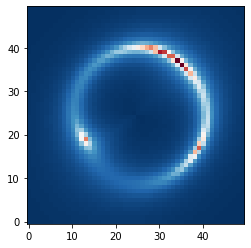

In [4]:
# Set up cosmology, marking H0 as dynamic
cosmo = FlatLambdaCDMCosmology("cosmo", h0=None)

# Static SIE args: z_l, thx0, thy0, q, phi, b
x_lens = torch.tensor([0.0, 0.0, 0.8, pi / 6, 1.5])
try:
    sie = SIE("cosmo", cosmo, None, *x_lens)
except KeyError as e:
    print("caught exception: ", e, "\n")

sie = SIE("sie", cosmo, None, *x_lens)

# Static Sersic args: q, phi, index, th_e, I_e
x_src = torch.tensor([0.6, pi / 4, 4.0, 2.5, 1.0])
src = Sersic("src", None, None, *x_src)

sim = Simulator(0.1, 50, sie, src, torch.tensor(0.8))
print(sim, "\n")
print(sie, "\n")
print(cosmo, "\n")
print(src, "\n")

print("testing x size error checking:")
x = torch.tensor([])
try:
    sim.x_to_dict(x)
except ValueError as e:
    print("caught exception: ", e, "\n")

print("running with valid argument vector")
x = torch.tensor([0.8, 0.7, 0.13, 0.04])
plt.imshow(sim(x), origin="lower", cmap="RdBu_r")
print()

print("vmap shape check:", vmap(sim)(x.repeat(10, 1)).shape)

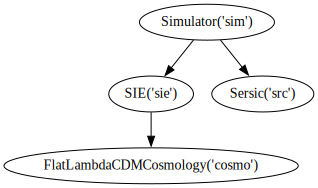

In [5]:
sim.get_graph()

In [6]:
sim.sie_2 = SIE("sie_2", cosmo)
src.child = cosmo.child = FlatLambdaCDMCosmology("dummy")

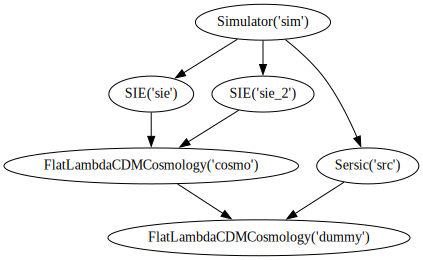

In [7]:
sim.get_graph()

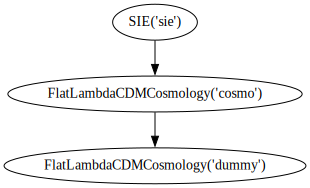

In [8]:
sie.get_graph()

In [10]:
sim.get_graph(True, True).render("/Users/amcoogan/Downloads/sim-weird")

'/Users/amcoogan/Downloads/sim-weird.pdf'

There are a few things I'm not clear on with this approach.
- In this approach, I don't think we can't run the same model component on different parameters: through the component's name, it's tied to one set of parameters in `x`. This makes it expensive to do things like include multiple `KappaGrid` lenses: each set of `Param`s must be associated with one `KappaGrid`, so we need to create a redundant set of kernels.
- How should we handle `Param`s like `z_s`? In what's above, I made this a parameter of the simulator, but that means we have to explicitly pass it to `raytrace`. How will this generalize?
- Is it confusing that names of `Param`s and `Parametrized` don't match the names of the attributes they're bound to?